<a href="https://colab.research.google.com/github/dandoreyrodriguez/Bayesian_Econometrics/blob/main/BE_Koop_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Class 1 in Bayesian Econometrics**

## **Motivation**

This is the first in a series of notebooks which document my journey learning Bayesian econometrics. It is intended for people who, like me, have zero background in Bayesian statistics but have a background in statistics/econometrics. The point of this is not to mimic a textbook, but to show how I slowly begin to understand things. My hope is that I can closely track the difficulties other new students encounter, and that the reader can learn from them. The reason I figured I had to learn Bayesian statistics is that Bayesian techniques offer versatility within a relatively simple framework. Compare this to a Kalman Filter, which requires normality and hence is not very general as a statistical approach. A large goal of this series is to help new students learn to use Bayesian tools in python, chiefly `pyMC`, since computation is crucial to Bayesian statistics.

I learn by doing. In this intro class, I consider two models: a very basic binomial model and a normal linear regression model. Using these examples, I demonstrate what doing Bayesian statistics looks like and show the main objects of interest in Bayesian econometrics. In each case, I give an example where an analytical solution can be found by hand. I also show who computational methods are so important.

I do not shy away from doing statistical theory as I am a firm believer that practitioners should not use techniques whose theoretical properties they do not understand. If the reader struggles with this, I hope they may find comfort in knowing that I did too.

The single most useful resource I found online was this pyData [talk](https://www.youtube.com/watch?v=911d4A1U0BE&t=773s). The binomial example is taken directly from this talk.

Future notebooks will go over other applications. My goal in this series is to reach state space time series models and perhaps general equilibrium macro models---if I am lucky.

Happy learning.


## **A Binomial Model**

Imagine you were interested in estimating the probability, $\theta \in [0,1]$, that a baseball batter strikes out from data corresponding to $n$ plate appearances. Suppose that in $n$ appearances, or trials, the batter strikes out $y \in \{0, 1, \cdots, n\}$ times. If these trials are independent, then $P(y|\theta) = \frac{n!}{y! (n-y)! } \theta^y (1-\theta)^{n-y}$ is the probability mass function corresponding to $y$. That is, the number of times the batter strikes out follows the familiar binomial distribution.

A Bayesian wants to learn about the *posterior* distribution which characterises uncertainty regarding the parameter after having seen the data. In this example, everything is one dimensional, and hence simple. In this case, the posterior, $f(\theta|y)$, will be a probability density function.

Using Bayes rule,

$$ f(\theta | y) = \frac{f(y|\theta)f(\theta)}{f(y)}$$

Let's inspect these objects one by one:
- $f(y|\theta)$ is simply the likelihood function. In the discrete case, the likelihood function *is* the probability mass function, $P(y|\theta)$. The likelihood function is familiar to us from when we do frequentist statistics!
- $f(\theta)$ is the prior distribution. It characterises the statistician's uncertainty about the true strikeout rate before seeing the data. In our case, this will be a continuous probability density function.
- $f(y)$ is the marginal evidence. It is the probability of observing the data given our uncertainty about the parameter prior to seeing the data. It is called the marginal to emphasises that you integrate/sum out $\theta$ using the prior. More formally, $f(y) = \int_0^1f(y|\theta) f(\theta)d\theta$.

To obtain the posterior, we need to specify the prior, $f(\theta)$. For now, I will make it a Beta distribution because it is defined on the unit line. The Beta distribution $\text{Beta}(\alpha, \beta)$ has a PDF:

$$f(\theta) = \frac{1}{\text{B}(\alpha, \beta)}\theta^{\alpha-1}(1-\theta)^{1-\beta}, \forall \theta \in [0,1], \, \forall \alpha, \beta>0$$

The beta function is defined, $\text{B}(\alpha, \beta) := \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha+\beta)}$. In turn, the Gamma function is defined: $\Gamma(z) := \int_{0}^\infty t^{z-1} e^{-t}dt$. The important point is that the Gamma function is just a definite integral, and so it it is constant! This means that the Beta function is just some constant.

Here is what a Beta distribution looks like for different parameter values. Note that it nests the uniform distribution.

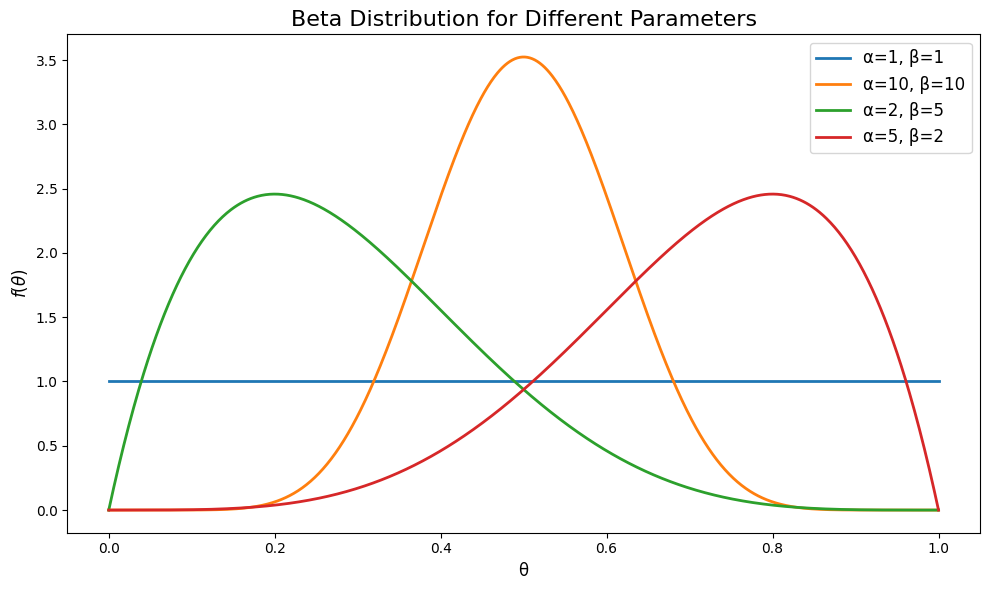

In [9]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Create an array of x values from 0 to 1
x = np.linspace(0, 1, 1000)

# Define a list of (alpha, beta) parameter pairs for the Beta distributions
params = [
    (1, 1),
    (10, 10),
    (2, 5),
    (5, 2)
]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each Beta distribution
for a, b in params:
    pdf = beta.pdf(x, a, b)
    plt.plot(x, pdf, lw=2, label=f'α={a}, β={b}')

# Add labels, title, and legend to the plot
plt.xlabel('θ', fontsize=12)
plt.ylabel(r'$f(\theta)$', fontsize=12)
plt.title('Beta Distribution for Different Parameters', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


Next, an important thing to note is that the posterior $f(\theta|y)$ fixes the value of the data. So as you vary $\theta$, $y$ remains constant. Hence, the marginal evidence, $f(y)$, is simply a scaling constant which ensures that $f(\theta|y)$ integrated to one and is a valid PDF.

Plugging everything we have in:

$$  f(\theta|y) = \frac{\frac{n!}{y! (n-y)! } \theta^y (1-\theta)^{n-y} \cdot \theta^{\alpha-1}(1-\theta)^{\beta-1} }{\text{B}(\alpha, \beta) f(y)}  $$

Grouping all the terms which are constant into some $k>0$:

$$ f(\theta|y) = k \theta^{y+\alpha-1}(1-\theta)^{n-y+\beta-1} $$

But hang on...this looks like a Beta distribution again! In fact, it looks like $\theta|y \sim \text{Beta}( y+\alpha, n-y+\beta) $.

How extraordinary. Given our choice of prior, once we knew how many times the batter struck out in their $n$ plat appearances, $y$, we learned the posterior! This example has two great properties:

1.  The posterior distribution is a Beta distribution and the prior distribution is a Beta distribution. This property is called *conjugacy*. This is when your choice of prior ensures that the posterior distribution belongs to the same family as the prior.
2. We didn't have to worry about the pesky constant term because we spotted that the posterior was a $\text{Beta}( y+\alpha, n-y+\beta) $. With this information, we know what the constant term is from the PDF. It's like we get it for free. This is a relief because the beta function, factorials, and marginal evidence term were starting to give me shivers...

## **Linear Regression**

A linear regression model is the most convenient/basic model to think about. I start with this example because it is what I, and most others, know best.

Suppose that $\boldsymbol{y}$ is a $n \times 1 $ vector of data and $\boldsymbol{X}$ is a $n \times k$ design matrix. The $i$th row of this matrix is $\boldsymbol{x}_i'$, where $\boldsymbol{x}_i$ is a $k\times1$ vector which stores each of the features, or independent variables, for that observation. A normal linear regression model is:

$$\boldsymbol{y}= \boldsymbol{X}\boldsymbol{\beta}+\boldsymbol{\epsilon}, \, \boldsymbol{\epsilon} \overset{\text{i.i.d}}{\sim} \text{N}(\boldsymbol{0}, h^{-1} \boldsymbol{I})$$

Normality ensures homoskedasticity and serially-uncorrelatedness of errors.  $h = \sigma^{-2}$ is a measure of "tightness" of errors. $\boldsymbol{\beta}$ is the $k \times 1$ vector of parameters of interest.A *frequentist* treats $\boldsymbol{\beta}$ and $h$ as constant (i.e. given) but unknown.

But how would a *Bayesian* learn about $\boldsymbol{\beta}$ and $h$? Well, start with Bayes' rule!

The parameters of inetrest are $\boldsymbol{\theta} = [ \boldsymbol{\beta}, h]'$. So:

$$ f(\boldsymbol{\theta} |\boldsymbol{X}, \boldsymbol{y}) = \frac{f(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{\theta} )f(\boldsymbol{\theta} | \boldsymbol{X})}{f(\boldsymbol{y}|\boldsymbol{X})}$$

Now we inspect each object on the right hand side.

- $f(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{\theta} )$ takes the parameters and explanatory variables as given. That is, it is the likelihood function that we are familiar with from our frequentist training (it is what we use in maximum likelihood!)
- $f(\boldsymbol{\theta} | \boldsymbol{X})$ is the prior distribution. It is some probability distribution over the parameter space *before* you see the data

Start by considering the likelihood function. In this model, observations are normally distributed:

$$\boldsymbol{y}|\boldsymbol{X},\boldsymbol{\beta},h \overset{\text{i.i.d}}{\sim} \text{N}(\boldsymbol{X}\boldsymbol{\beta}, h^{-1} \boldsymbol{I})$$

The likelihood function is simlpy the joint probability density function of the data.

$$f(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{\beta},h) = (2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}}  \text{exp}\bigg( -\frac{h}{2}(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})' (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})\bigg),  \forall \boldsymbol{\beta} \in \mathbb{R}^n $$

The next step is to specify priors. We are going to make a very informed guess. Why will become obvious after the fact. Suppose that our priors are:

- $\boldsymbol{\beta} \sim \text{N}(\boldsymbol{\beta}_0, \boldsymbol{V}_0)
$
- $h \sim \text{Gamma}(\alpha_0, \beta_0)$

Using the normal and gamma density functions:

$$ f(\boldsymbol{\beta}) = (2 \pi)^{-\frac{k}{2}} |\boldsymbol{V}_0|^{-\frac{1}{2}}  \text{exp}\bigg( -\frac{1}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_0)' \boldsymbol{V}_0^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_0)\bigg), \forall \boldsymbol{\beta} \in \mathbb{R}^{k} $$

$$ f(h) = \frac{1}{\Gamma(\alpha_0)}\beta_0^{\alpha_0} h^{\alpha_0-1} \text{exp}\bigg(-h\beta_0\bigg), \forall h \geq 0$$

Recall from the first section that the posterior can be written in the following way:

$$ f(\boldsymbol{\beta}, h | \boldsymbol{X}, \boldsymbol{y} ) \propto f(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{\beta},h) f(\boldsymbol{\beta}) f(h)$$

This gives a long expression:

$$ f(\boldsymbol{\beta}, h | \boldsymbol{X}, \boldsymbol{y} ) \propto h^{\frac{n}{2}}  \text{exp}\bigg( -\frac{h}{2}(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})' (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}) -\frac{1}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_0)' \boldsymbol{V}_0^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_0)-h\beta_0\bigg) h^{\alpha_0-1} $$

However, it is actually easier to spot conditional probabilities than joint probabilities. This is because you can treat the other argument as given and treat it as part of the scaling constant term. Again, to turn to Baye's rule:

$$f(\boldsymbol{\beta} |h, \boldsymbol{X}, \boldsymbol{y} ) = \frac{f(\boldsymbol{\beta}, h | \boldsymbol{X}, \boldsymbol{y} )}{f(h| \boldsymbol{X}, \boldsymbol{y})} $$

The conditional distribution has the same functional form as the joint distribution if you treat $h$ as constant, up to some scaling parameter.
